In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools

In [4]:
results = evallm.experiments.transducer_experiment.current_transducer_experiments()

In [17]:
relative_to_null = pd.DataFrame(
    {
        num_states: {
            num_sequence_symbols: np.mean(
                [
                    x.success_rate_binary >= x.null_success_rate
                    for x in results[num_states][num_sequence_symbols]
                ]
            )
            for num_sequence_symbols in results[num_states]
        }
        for num_states in results
    }
)

In [6]:
def plot_relative_results(relative, name):
    plt.figure(dpi=200)
    for k in relative:
        plt.plot(relative[k].index, relative[k] * 100, label=f"{k} states")
    plt.legend()
    plt.xlabel("Sequence Length")
    plt.ylabel(f"Meets {name} %")
    plt.axhline(50, color="black")
    plt.grid()
    plt.show()

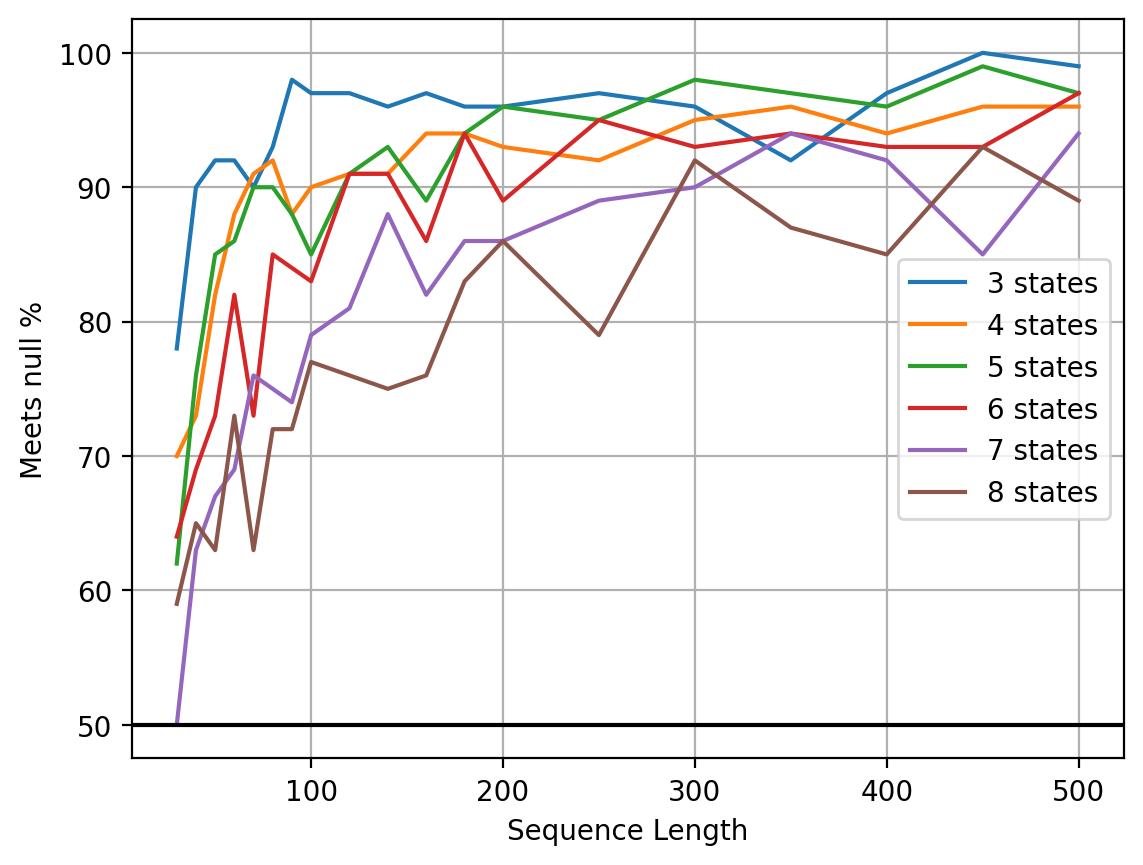

In [18]:
plot_relative_results(relative_to_null, "null")

In [8]:
relative_to_kgram = lambda k, results: pd.DataFrame(
    {
        num_states: {
            num_sequence_symbols: np.mean(
                [
                    x.success_rate_binary_meets_kgram >= k
                    for x in results[num_states][num_sequence_symbols]
                ]
            )
            for num_sequence_symbols in results[num_states]
        }
        for num_states in results
    }
)

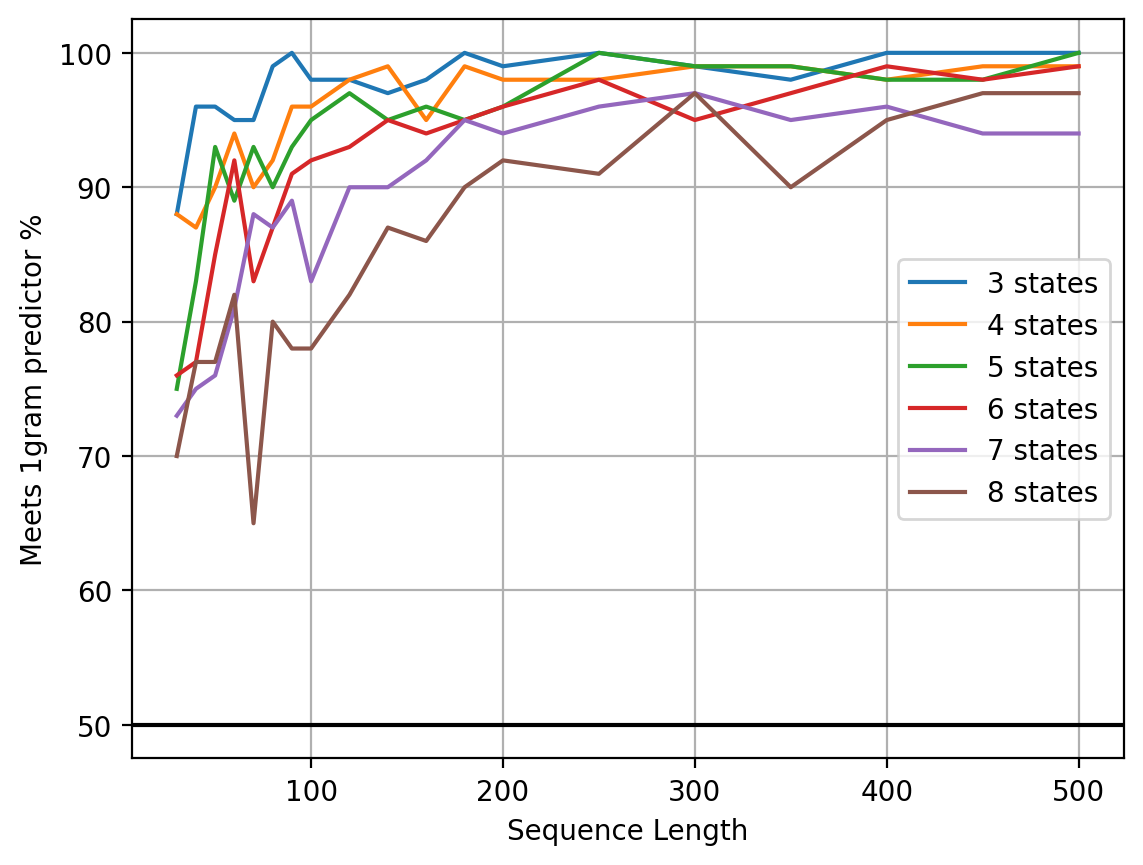

In [9]:
plot_relative_results(relative_to_kgram(1, results), "1gram predictor")

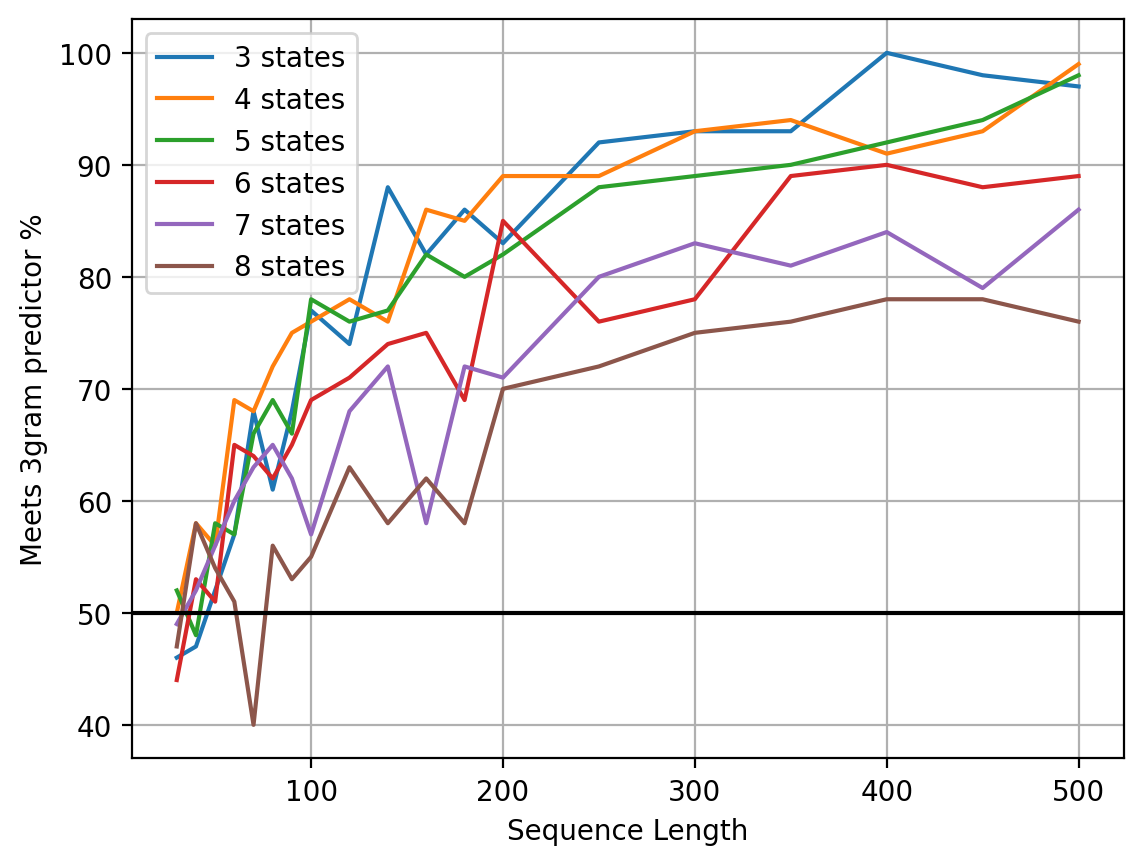

In [10]:
plot_relative_results(relative_to_kgram(2, results), "3gram predictor")

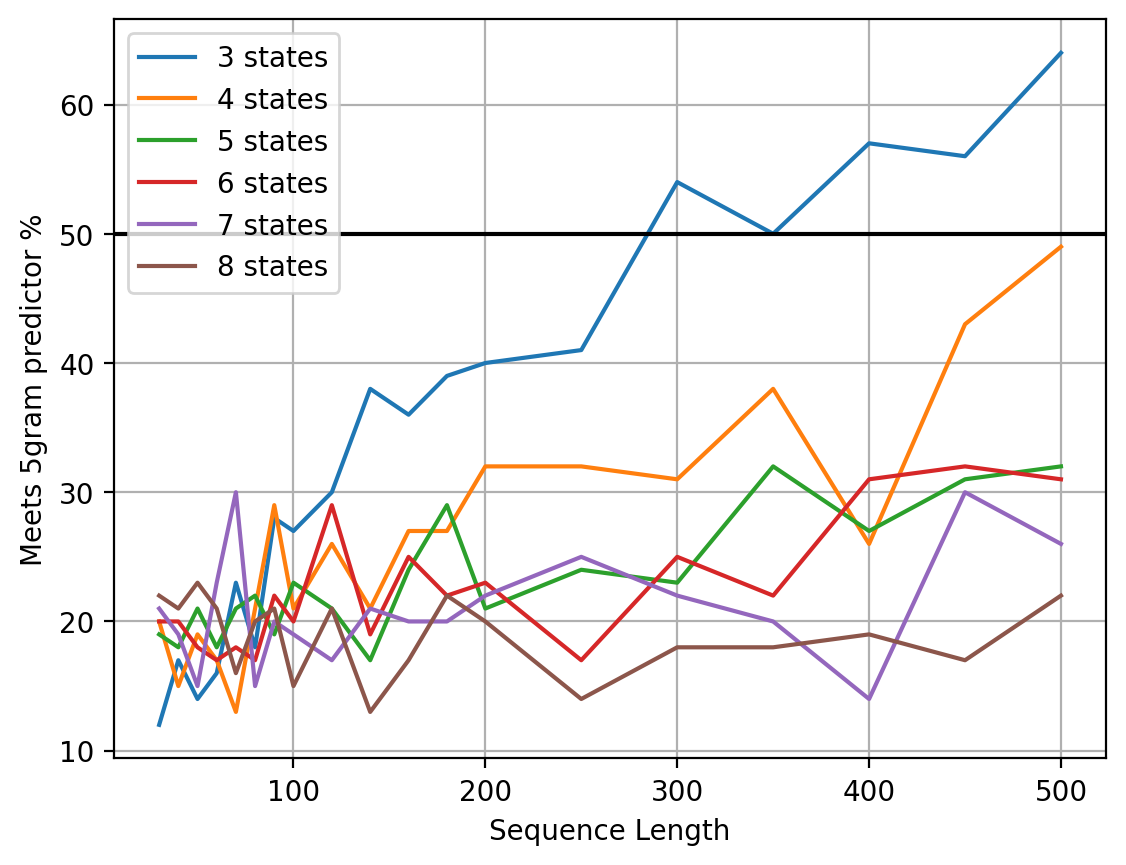

In [11]:
plot_relative_results(relative_to_kgram(5, results), "5gram predictor")

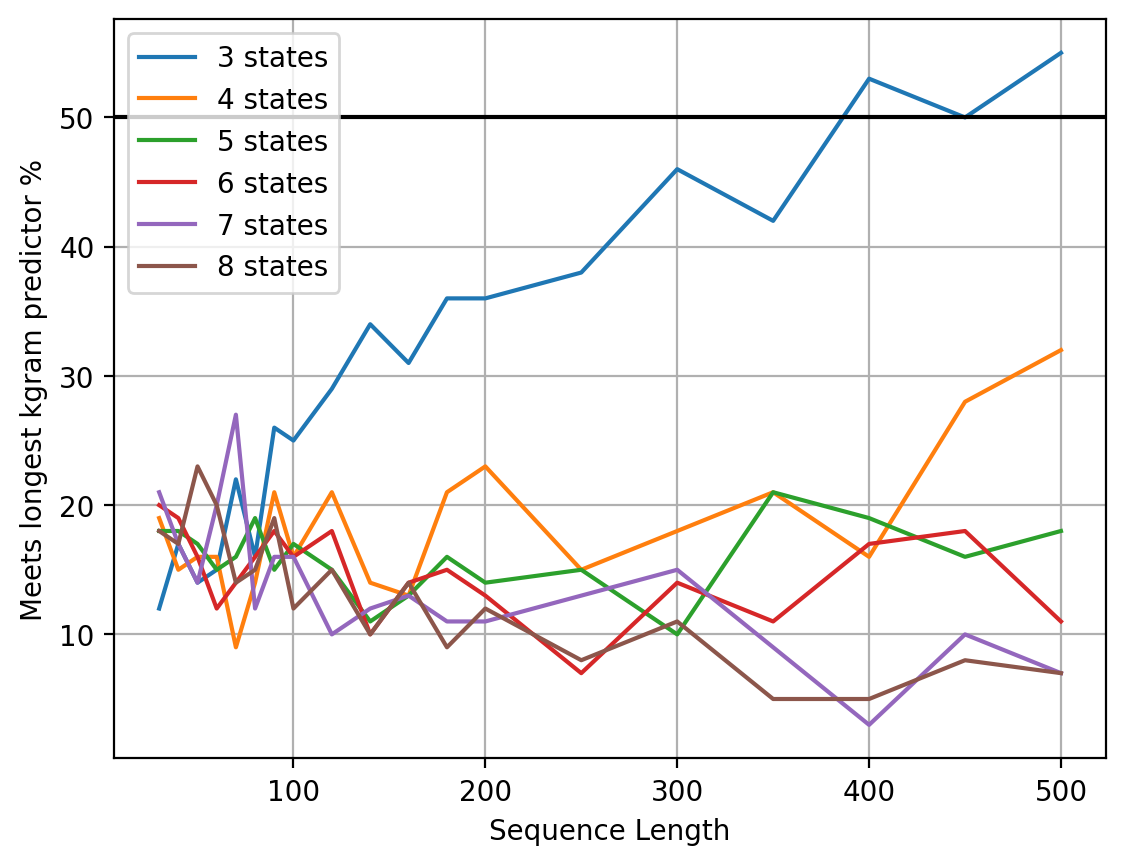

In [12]:
plot_relative_results(relative_to_kgram(10**9, results), "longest kgram predictor")

In [13]:
results_chatgpt = (
    evallm.experiments.transducer_experiment.chatgpt_transducer_experiments()
)

In [14]:
relative_to_null_chatgpt = pd.DataFrame(
    {
        num_states: {
            num_sequence_symbols: np.mean(
                [
                    x.success_rate_binary >= x.null_success_rate
                    for x in results_chatgpt[num_states][num_sequence_symbols]
                ]
            )
            for num_sequence_symbols in results_chatgpt[num_states]
        }
        for num_states in results_chatgpt
    }
)

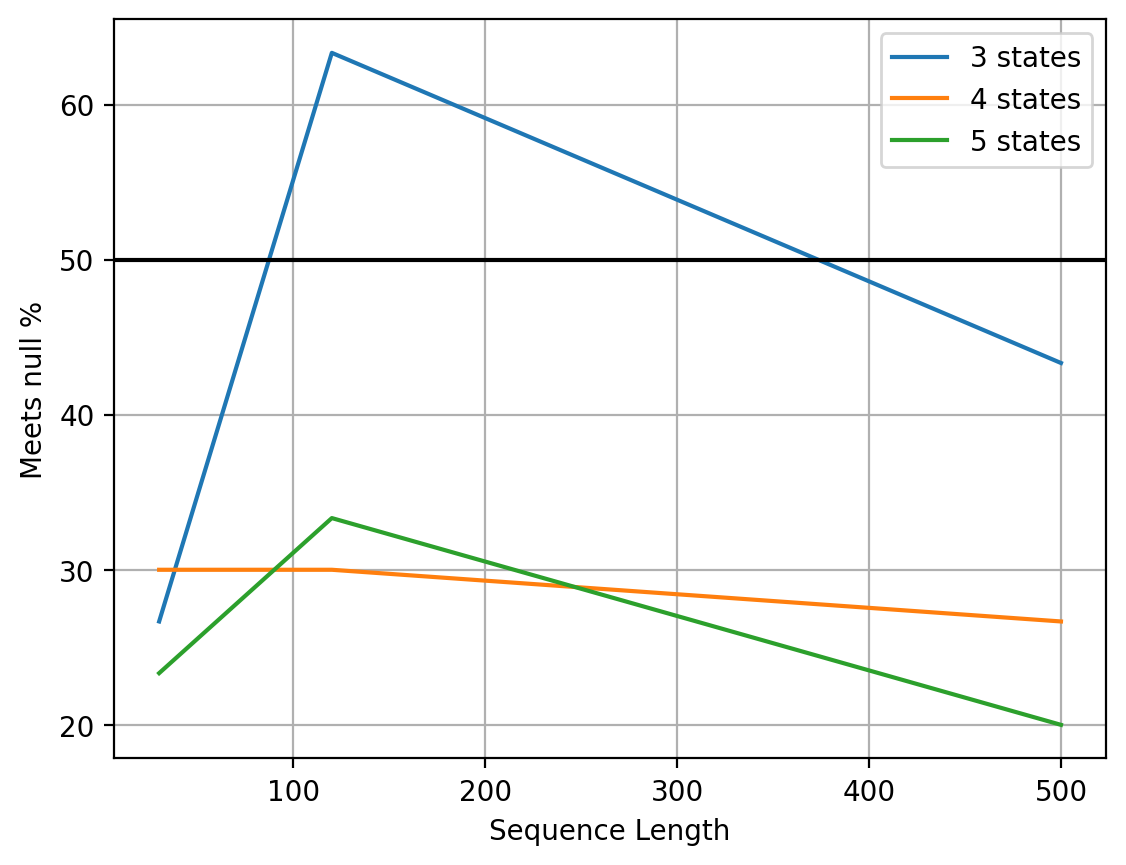

In [15]:
plot_relative_results(relative_to_null_chatgpt, "null")

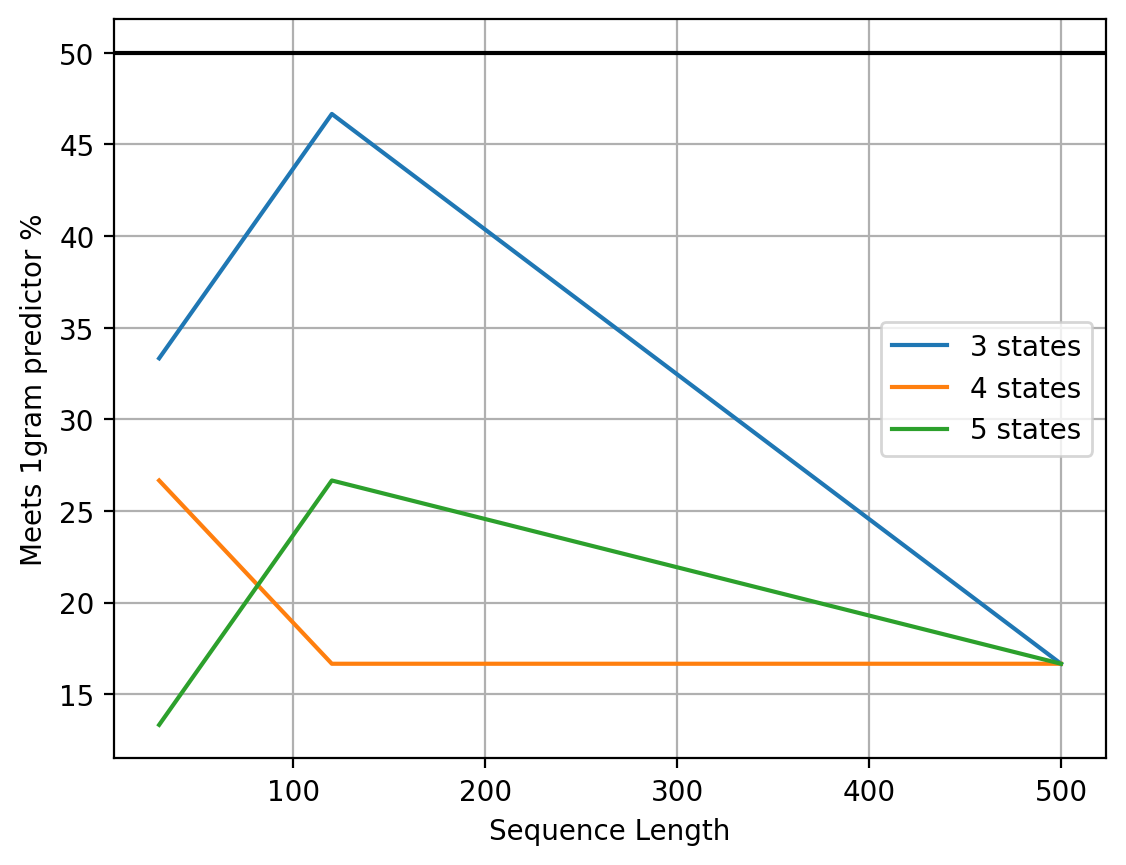

In [16]:
plot_relative_results(relative_to_kgram(1, results_chatgpt), "1gram predictor")

ChainOfThoughtPrompt(30, 3)

In [46]:
prompter = evallm.prompting.transducer_prompt.ChainOfThoughtPrompt(30)
bad_outcome = [x for x in results_chatgpt[3][30] if x.success_rate_binary < 0.5][0]

In [34]:
with evallm.llm.run_prompt.error_on_miss():
    out = evallm.llm.run_prompt(
        "gpt-3.5-turbo-0125", bad_outcome.prompts, {"max_tokens": 5000}
    )

In [61]:
for i, prompt, output, real_output in zip(
    itertools.count(), bad_outcome.prompts, out.choices, bad_outcome.outputs
):
    correctness = np.diag(prompter.score_completion(real_output[-1], output)).sum()
    correctness_string = {1: "CORRECT", 0: "WRONG", 0.5: "NA"}[correctness]
    print(f"********* EXAMPLE {i}: {correctness_string} ***********")
    print("######### SYSTEM ############")
    print(prompt["system"])
    print("######### USER ############")
    print(prompt["user"])
    print(f"######### RESPONSE: {correctness_string} ############")
    print(output.message.content)
    print()

********* EXAMPLE 0: CORRECT ***********
######### SYSTEM ############
You are a question answering system. For each question, think step by step and place your answer between tags like <answer>0</answer> or <answer>1</answer>. MAKE SURE TO PUT YOUR ANSWER IN ANSWER TAGS or you will get NO CREDIT.
QUESTION:
What is 20*2?
ANSWER:
To solve this problem, we need to multiply 20 by 0. We can accomplish this via noticing that anything multiplied by 0 is 0. <answer>0</answer>

######### USER ############
QUESTION:
A DFA was used to create these outputs given a random sequence of inputs. Your job is to fill in the last output:
in: c, out: 0
in: a, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 0
in: c, out: 1
in: a, out: 0
in: c, out: 1
in: b, out: 0
in: c, out: 1
in: c, out: 0
in: c, out: 1
in: c, out: 0
in: a, out: 0
in: b, out: 1
in: c, out: 0
in: b, out: 0
in: a, out: 0
in: c, out: 0
in: b, out: 1
in: b, out: 0
in: c, out: 1
in: a, out: 0
in: c, out: 1
in: a, out: 0
in: b, out: 0
in: a, ou